## Bibliotecas para o projeto

In [1]:
# Análise e visualização dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Decomposição e avalição da série temporal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Machine Learning
from prophet import Prophet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Pré-processamento dos dados

### Importação dos dados para o notebook

In [2]:
df = pd.read_csv("/content/Dados Históricos - Ibovespa - 10_Anos.csv", sep=',')

### Compreendendo o conjunto de dados

In [3]:
print("Estrutura dos dados - ", df.shape[0], "linhas e", df.shape[1], "colunas", "\n")
df.head()

Estrutura dos dados -  2481 linhas e 7 colunas 



,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,18.07.2025,133.382,135.562,135.562,133.296,"10,07B","-1,61%"
1,17.07.2025,135.565,135.515,135.792,135.016,"6,80B","0,04%"
2,16.07.2025,135.511,135.250,135.641,134.265,"7,83B","0,19%"
3,15.07.2025,135.250,135.298,136.022,134.380,"6,90B","-0,04%"
4,14.07.2025,135.299,136.187,136.187,134.840,"7,33B","-0,65%"


### Renomeando as colunas

In [4]:
df = df.rename(columns={'Vol.': 'Volume',
                        'Var%': 'Variacao',
                        'Máxima': 'Maxima',
                        'Mínima': 'Minima',
                        'Último':'Ultimo'})

In [5]:
df

,Data,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
0,18.07.2025,133.382,135.562,135.562,133.296,"10,07B","-1,61%"
1,17.07.2025,135.565,135.515,135.792,135.016,"6,80B","0,04%"
2,16.07.2025,135.511,135.250,135.641,134.265,"7,83B","0,19%"
3,15.07.2025,135.250,135.298,136.022,134.380,"6,90B","-0,04%"
4,14.07.2025,135.299,136.187,136.187,134.840,"7,33B","-0,65%"
...,...,...,...,...,...,...,...
2476,24.07.2015,49.246,49.804,49.831,48.624,"3,74M","-1,13%"
2477,23.07.2015,49.807,50.916,51.063,49.668,"4,31M","-2,18%"
2478,22.07.2015,50.916,51.474,51.474,50.592,"3,22M","-1,08%"
2479,21.07.2015,51.474,51.603,51.998,51.244,"3,03M","-0,24%"


### Tipo dos dados

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2481 non-null   object 
 1   Ultimo    2481 non-null   float64
 2   Abertura  2481 non-null   float64
 3   Maxima    2481 non-null   float64
 4   Minima    2481 non-null   float64
 5   Volume    2480 non-null   object 
 6   Variacao  2481 non-null   object 
dtypes: float64(4), object(3)
memory usage: 135.8+ KB


Na análise das informações básicas sobre os tipos dos dados encontrados, identificamos que a variável **Data** está no tipo incorreto, object. Assim como as variáveis **Vol.** e **Var%**.

Como estamos falando de uma série temporal, é de extrema importância, que as datas sejam transformadas para o padrão correto, datetime e float.

### Transformando tipo da variável **Data**

In [7]:
df['Data'] = pd.to_datetime(df['Data'], format = "%d.%m.%Y")

#### Validando a transformação

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      2481 non-null   datetime64[ns]
 1   Ultimo    2481 non-null   float64       
 2   Abertura  2481 non-null   float64       
 3   Maxima    2481 non-null   float64       
 4   Minima    2481 non-null   float64       
 5   Volume    2480 non-null   object        
 6   Variacao  2481 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 135.8+ KB


Após a transformação do tipo, podemos ampliar a assertividade do modelo alterando nossa variável **Data** para índice e ordenando-a. Desta forma, o modelo terá uma maior facilidade na leitura dos dados e garantirá que as operações sigam a ordem cronológica do tempo.

#### Transformação da variável em índice e reordenando-a de forma sequencial

In [9]:
df.set_index('Data', inplace=True)

In [10]:
df = df.sort_values('Data')

In [11]:
df.head()

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
2015-07-20,51.600,52.341,52.424,51.525,"2,72M","-1,42%"
2015-07-21,51.474,51.603,51.998,51.244,"3,03M","-0,24%"
2015-07-22,50.916,51.474,51.474,50.592,"3,22M","-1,08%"
2015-07-23,49.807,50.916,51.063,49.668,"4,31M","-2,18%"
2015-07-24,49.246,49.804,49.831,48.624,"3,74M","-1,13%"


### Transformando o tipo da variável **Variacao**

In [12]:
df["Variacao"] = df["Variacao"].str.replace(",", ".").str.replace("%", "").astype(float)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2481 entries, 2015-07-20 to 2025-07-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ultimo    2481 non-null   float64
 1   Abertura  2481 non-null   float64
 2   Maxima    2481 non-null   float64
 3   Minima    2481 non-null   float64
 4   Volume    2480 non-null   object 
 5   Variacao  2481 non-null   float64
dtypes: float64(5), object(1)
memory usage: 135.7+ KB


,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
2015-07-20,51.600,52.341,52.424,51.525,"2,72M",-1.42
2015-07-21,51.474,51.603,51.998,51.244,"3,03M",-0.24
2015-07-22,50.916,51.474,51.474,50.592,"3,22M",-1.08
2015-07-23,49.807,50.916,51.063,49.668,"4,31M",-2.18
2015-07-24,49.246,49.804,49.831,48.624,"3,74M",-1.13


### Transformando o tipo da variável **Volume**

#### Encontrando os padrões e tratando-os

In [13]:
df["Volume"].astype(str).str[-1].unique()

array(['M', 'n', 'K', 'B'], dtype=object)

Encontramos informações na casa de milhões, milhares e bilhões. Para tratar a informação, criamos uma função que remove o caractere encontrao no final do número e faz a conversão para o volume real da informação.


In [14]:
def conversao_volume(volume): # -> função para converter object em float
  if isinstance(volume, str): # -> instanciado o dado a ser inputado como do tipo string (object)
    volume = volume.replace(".", "").replace(',', '.').strip() # -> Normalizando os separadores e possíveis espaços em branco na célula
    if volume.endswith("M"): # -> Identificando se o valor terminar em M
      return float(volume[:-1]) * 1_000_000 # -> Transformação em float e multplicação para exibição do número como um todo
    elif volume.endswith("B"): # -> Identificando se o valor terminar em B
      return float(volume[:-1]) * 1_000_000_000
    elif volume.endswith("K"): # -> Identificando se o valor terminar em K
      return float(volume[:-1]) * 1_000
    else:
      return float(volume)
  return volume

df["Volume"] = df["Volume"].apply(conversao_volume)

Validando a conversão do tipo da variável

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2481 entries, 2015-07-20 to 2025-07-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ultimo    2481 non-null   float64
 1   Abertura  2481 non-null   float64
 2   Maxima    2481 non-null   float64
 3   Minima    2481 non-null   float64
 4   Volume    2480 non-null   float64
 5   Variacao  2481 non-null   float64
dtypes: float64(6)
memory usage: 135.7 KB


O valor de 'n' refere-se a um valor nulo no dataset

In [16]:
df[df["Volume"].astype(str).str.contains('n')]

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
2016-02-10,40.377,40.592,40.592,39.96,NaN,-0.53


### Encontrando e tratando a valores nulos

In [17]:
df.isnull().sum() # -> Identificando valores nulos no dataset

,0
Ultimo,0
Abertura,0
Maxima,0
Minima,0
Volume,1
Variacao,0


#### Removendo os valores nulos

In [18]:
df.dropna(inplace=True)

#### Validando a remoção dos nulos

In [19]:
df.isnull().sum()

,0
Ultimo,0
Abertura,0
Maxima,0
Minima,0
Volume,0
Variacao,0


Após a remoção do registro em que havia um valor nulo na variável Volume, nosso dataset não possui mais nulidade nas informações.

### Encontrando e tratando duplicidade nos dados

Apesar de ser de uma origem baseada na série temporal configurada diariamente, é sempre uma boa prática analisarmos se existem dados duplicados no conjunto. Uma vez que precisamos encontrar todos os contextos que possam influenciar nosso modelo.

No nosso caso, não encontramos duplicidade nas informações.

In [20]:
df.duplicated().sum()

np.int64(0)

## Análise exploratória dos dados

### Estatística Descritiva dos dados

In [21]:
df.describe()

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
count,2480.000000,2480.000000,2480.000000,2480.000000,2.480000e+03,2480.000000
mean,96.514755,96.482694,97.336548,95.657876,5.522446e+08,0.049282
std,26.646151,26.650583,26.737334,26.548861,2.369331e+09,1.498762
min,37.497000,37.501000,38.031000,37.046000,4.243200e+05,-14.780000
25%,75.071500,75.000250,75.954250,74.315500,3.980000e+06,-0.720000
50%,102.941500,102.941500,104.052500,102.083000,7.810000e+06,0.060000
75%,117.848750,117.847500,118.704250,116.857250,1.129250e+07,0.840000
max,141.264000,141.265000,141.564000,140.597000,2.487000e+10,13.910000


### Avaliando o comportamento das variáveis ao longo do tempo

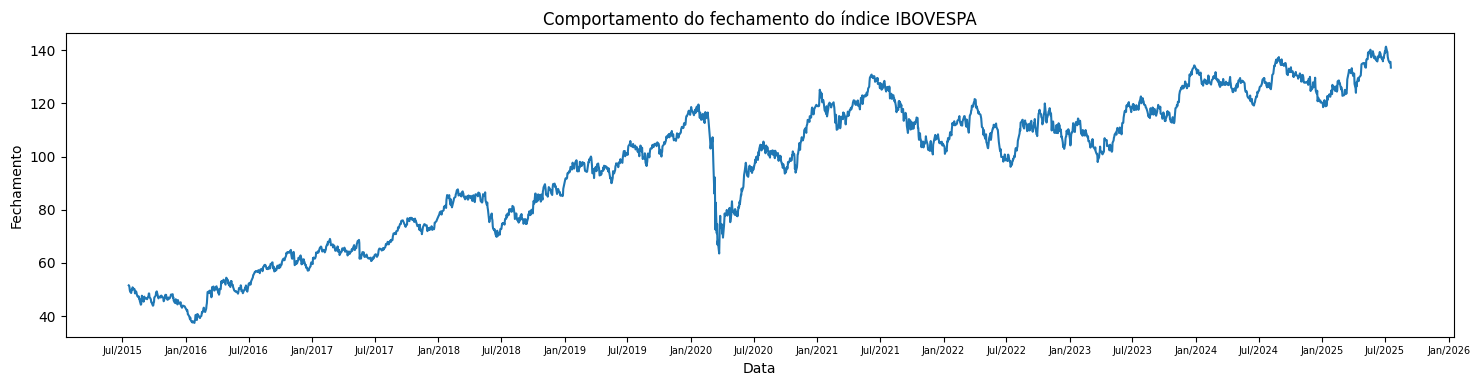

Podemos identificar que ao longo do tempo, o índice sofre um comportamento instável com períodos de altas e baixas e apesar da instabilidade é possível enxergar que o índice 
segue crescendo.


In [22]:
plt.figure(figsize=(15, 4))
plt.plot(df.index, df["Ultimo"])
plt.xlabel("Data")
plt.ylabel("Fechamento")
plt.title("Comportamento do fechamento do índice IBOVESPA")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # intervalo de 6 meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.tight_layout()
plt.xticks(fontsize=7)
plt.show();

print("Podemos identificar que ao longo do tempo, o índice sofre um comportamento instável com períodos de altas e baixas e apesar da instabilidade é possível enxergar que o índice \nsegue crescendo.")

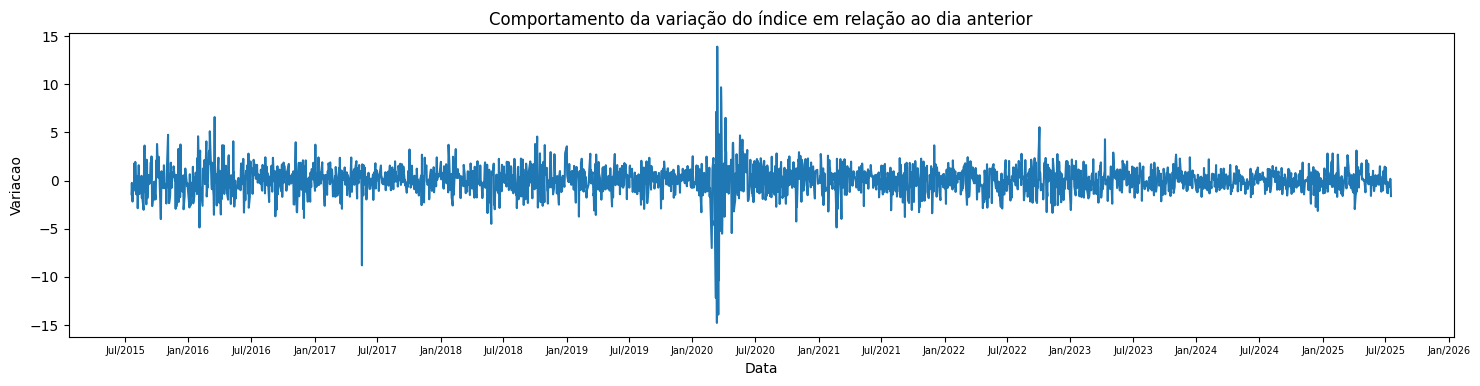

In [23]:
plt.figure(figsize=(15, 4))
plt.plot(df.index, df["Variacao"])
plt.xlabel("Data")
plt.ylabel("Variacao")
plt.title("Comportamento da variação do índice em relação ao dia anterior")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # intervalo de 6 meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.tight_layout()
plt.xticks(fontsize=7)
plt.show();

### Avaliação da distribuição de frequência das variáveis

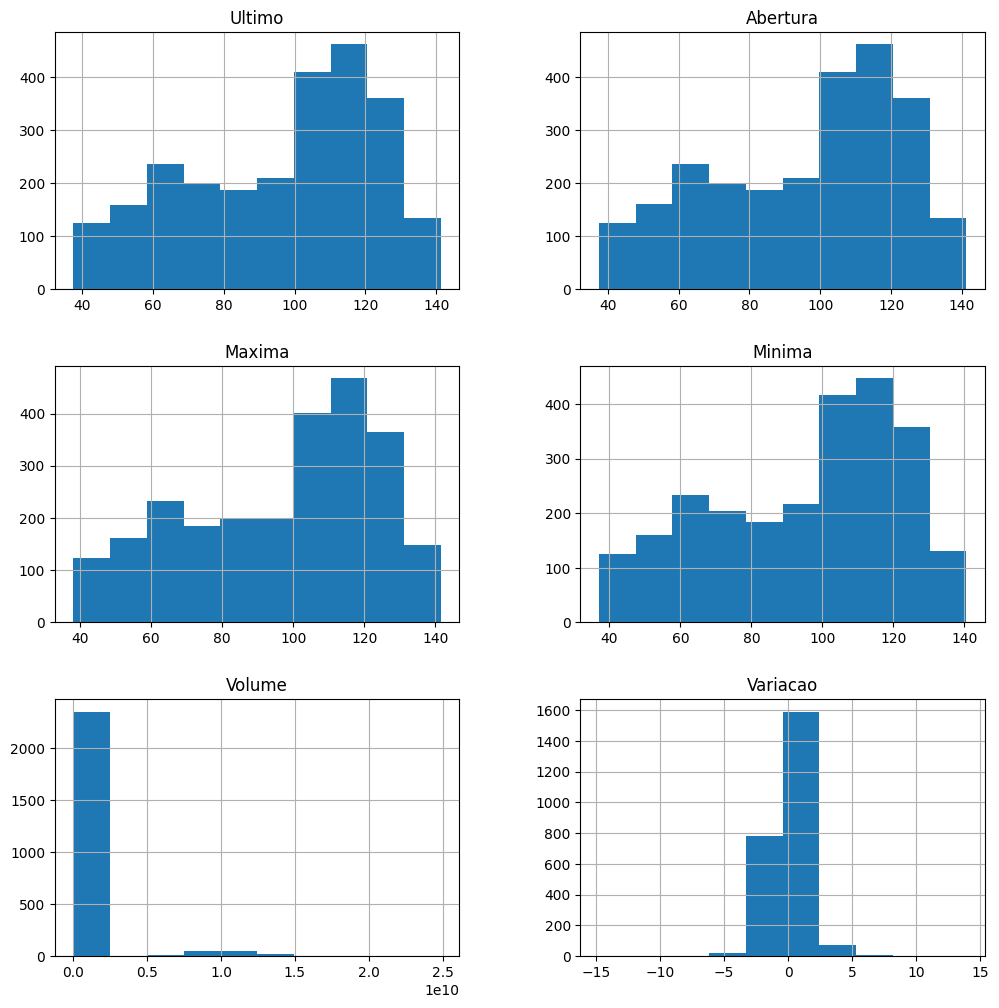

In [24]:
df.hist(figsize=(12,12));

### Decomposição da série temporal

- Tendência
- Sazonalidade
- Resíduos
- Valor Observado

In [25]:
dados = df[['Ultimo']]
dados.head()

,Ultimo
Data,
2015-07-20,51.600
2015-07-21,51.474
2015-07-22,50.916
2015-07-23,49.807
2015-07-24,49.246


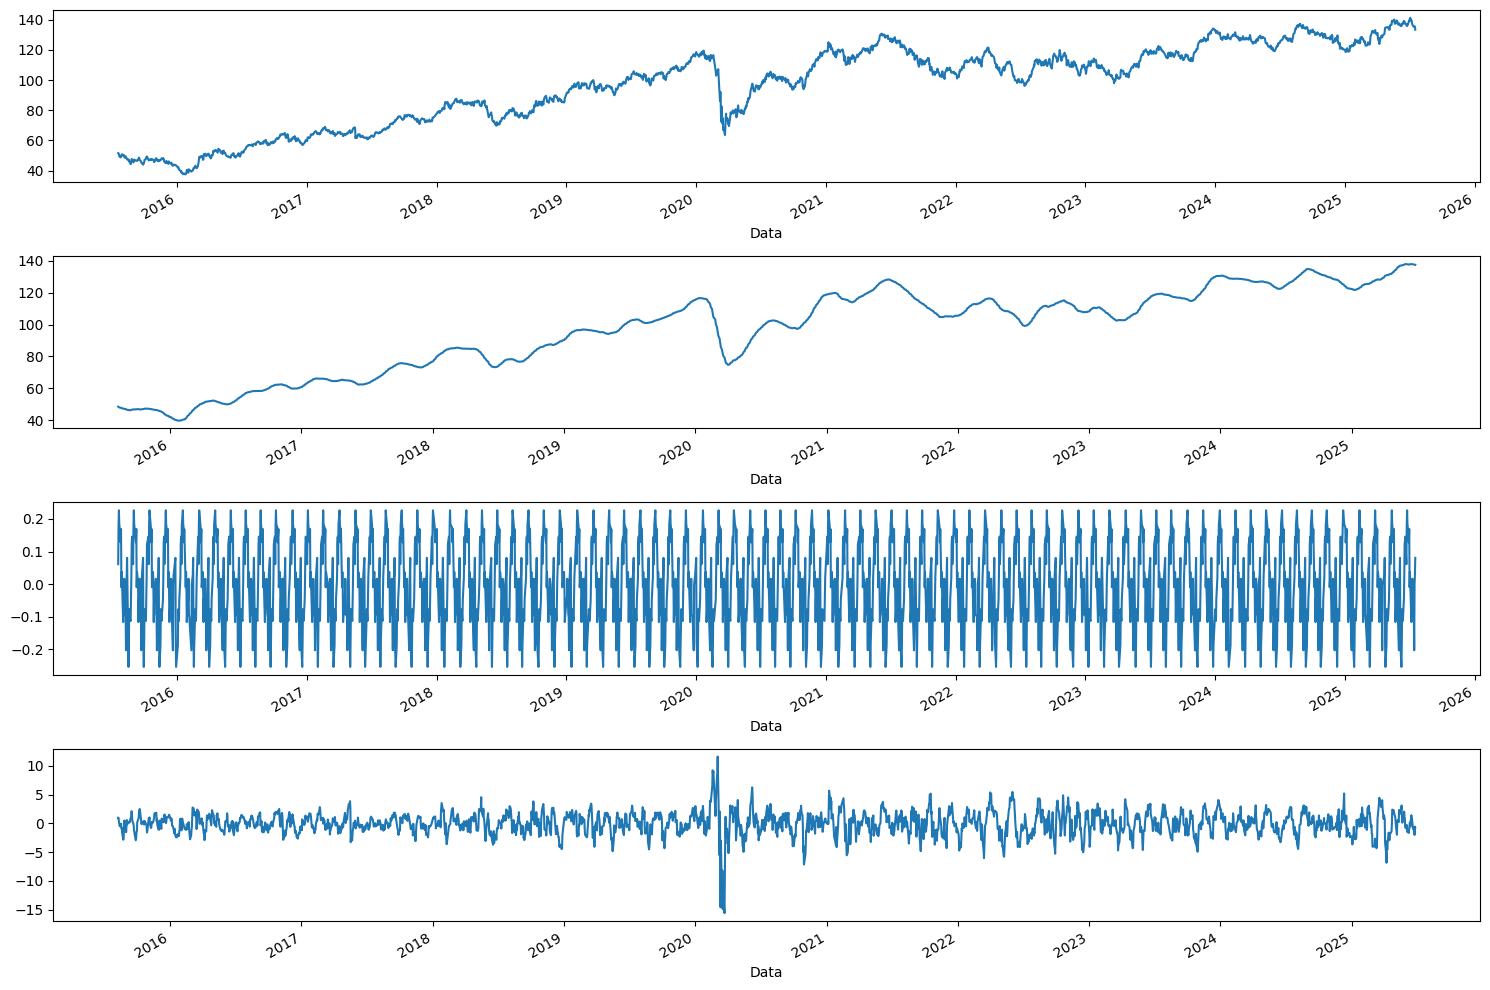

In [26]:
resultados = seasonal_decompose(dados, period=30)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()
plt.show();

### Avaliando a estacionaridade

In [27]:
X = df["Ultimo"].values

In [28]:
sns.set_style('darkgrid')
resultado = adfuller(X)

print('Teste ADF')
print(f'Teste Estatístico: {resultado[0]}')
print(f'P-Value: {resultado[1]}')
print('Valores críticos: ')

for key, y in resultado[4].items():
  print(f'\t{key}: {y}')

Teste ADF
Teste Estatístico: -1.5612598928650825
P-Value: 0.5030190581849556
Valores críticos: 
	1%: -3.432999172889712
	5%: -2.862710384473485
	10%: -2.5673930420019127


A série temporal não é Estacionária, pois o Teste Estatístico é menor do que o nosso P-Value.

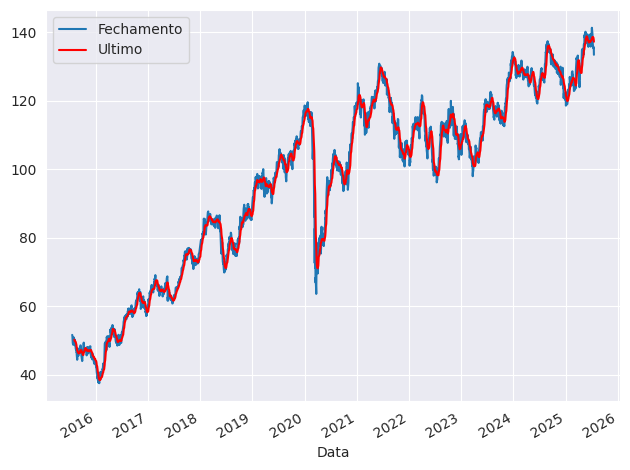

In [29]:
ma = dados.rolling(window=12).mean()

f, ax = plt.subplots()
dados['Ultimo'].plot(ax=ax, legend=False, label='Fechamento')
ma.plot(ax=ax, legend=False, color='r', label='Média Móvel')
plt.legend()
plt.tight_layout()
plt.show();

- Aplicação de transformação de escala com Log

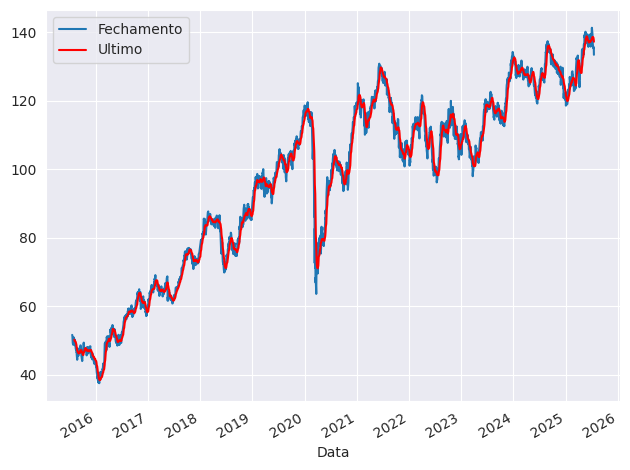

In [30]:
dados_log = np.log(dados)
ma_log = dados_log.rolling(window=12).mean()


f, ax = plt.subplots()
dados['Ultimo'].plot(ax=ax, legend=False, label='Fechamento')
ma.plot(ax=ax, legend=False, color='r', label='Média Móvel')
plt.legend()
plt.tight_layout()
plt.show()

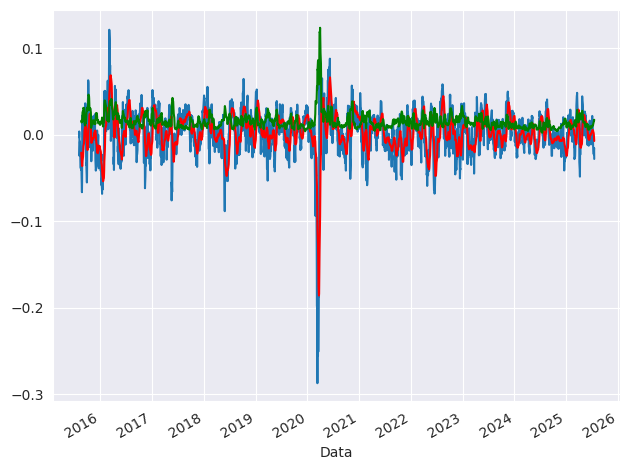

In [31]:
dados_s = (dados_log - ma_log).dropna()

ma_s = dados_s.rolling(window=12).mean()

std = dados_s.rolling(window=12).std()

f, ax = plt.subplots()
dados_s.plot(ax=ax, legend=False, label='Fechamento')
ma_s.plot(ax=ax, legend=False, color='r', label='Média Móvel')
std.plot(ax=ax, legend=False, color='g', label='Desvio Padrão')
plt.tight_layout()
plt.show();

- Série temporal convertida em uma série estácionaria através da transformação de log

In [32]:
X_s = dados_s["Ultimo"].values

resultado_s = adfuller(X_s)

print('Teste ADF')
print(f'Teste Estatístico: {resultado_s[0]}')
print(f'P-Value: {resultado_s[1]}')
print('Valores críticos: ')

for key, y in resultado_s[4].items():
  print(f'\t{key}: {y}')

Teste ADF
Teste Estatístico: -12.398984184359284
P-Value: 4.606261451359078e-23
Valores críticos: 
	1%: -3.4330099487687264
	5%: -2.8627151430515654
	10%: -2.5673955755408095


A série temporal ficou Estacionária, pois o Teste Estatístico é maior do que o nosso P-Value. Por fim, podemos rejeitar a hipótese nula.

### Avaliando a correlação entre as variáveis

<Axes: >

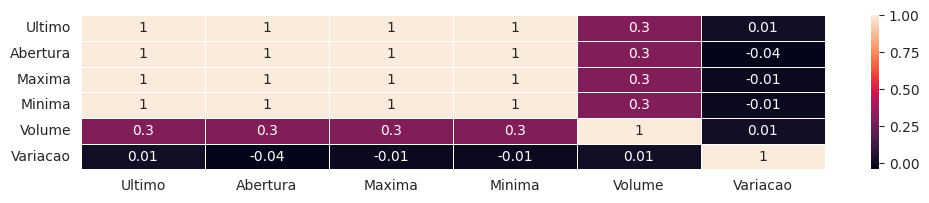

In [33]:
correlation_matrix = df.select_dtypes(include=np.number).corr().round(2)

fig, axs = plt.subplots(figsize=(12,2))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=axs)

## Tratando a Dataframe para os Modelos

In [34]:
df = df.reset_index('Data') # Transformando o Index de novo em coluna

In [35]:
dados = df[['Data', 'Ultimo']] # Selecionando as Colunas para o modelo

In [36]:
dados = dados.rename(columns={'Data': 'ds','Ultimo':'y'}) # Renomeando as colunas

In [37]:
dados.head()

,ds,y
0,2015-07-20,51.600
1,2015-07-21,51.474
2,2015-07-22,50.916
3,2015-07-23,49.807
4,2015-07-24,49.246


## Modelos Machine Learning

### Avaliação com o modelo estatístico **Prophet**



In [38]:
df_prophet = dados[['ds', 'y']].copy()

In [39]:
# Treino com base de 10 anos exceto os últimos 30 dias

df_train = df_prophet.iloc[:-30]
df_test = df_prophet.iloc[-30:]

In [40]:
# Treinamento do modelo

modelo = Prophet(daily_seasonality=True)
modelo.fit(df_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpku7ofxar/i1dhg3tm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpku7ofxar/d8_ljuvn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48802', 'data', 'file=/tmp/tmpku7ofxar/i1dhg3tm.json', 'init=/tmp/tmpku7ofxar/d8_ljuvn.json', 'output', 'file=/tmp/tmpku7ofxar/prophet_model2qndbxk7/prophet_model-20250803140951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [41]:
# Criar datas futuras e prever

future = modelo.make_future_dataframe(periods=30)
forecast = modelo.predict(future)

In [42]:
# Pegar somente as previsões dos últimos 30 dias

forecast_30 = forecast[['ds', 'yhat']].tail(30).reset_index(drop=True)
real_30 = df_test.reset_index(drop=True)

In [43]:
# Gerar classes com base na variação (alta ou queda)

# Para os reais:
real_30['y_class'] = (real_30['y'] > real_30['y'].shift(1)).astype(int)
real_30['y_class'] = real_30['y_class'].fillna(0)

# Para os previstos:
forecast_30['yhat_class'] = (forecast_30['yhat'] > forecast_30['yhat'].shift(1)).astype(int)
forecast_30['yhat_class'] = forecast_30['yhat_class'].fillna(0)

In [44]:
# Juntar e avaliar
comparacao = pd.concat([real_30, forecast_30['yhat_class']], axis=1)

In [45]:
# Avaliação com métricas de classificação
acc = accuracy_score(comparacao['y_class'], comparacao['yhat_class'])
print(f"Acurácia (Prophet como classificador): {acc:.2%}\n")

print("Classification Report:")
print(classification_report(comparacao['y_class'], comparacao['yhat_class']))

Acurácia (Prophet como classificador): 53.33%

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        18
           1       0.44      0.58      0.50        12

    accuracy                           0.53        30
   macro avg       0.54      0.54      0.53        30
weighted avg       0.56      0.53      0.54        30



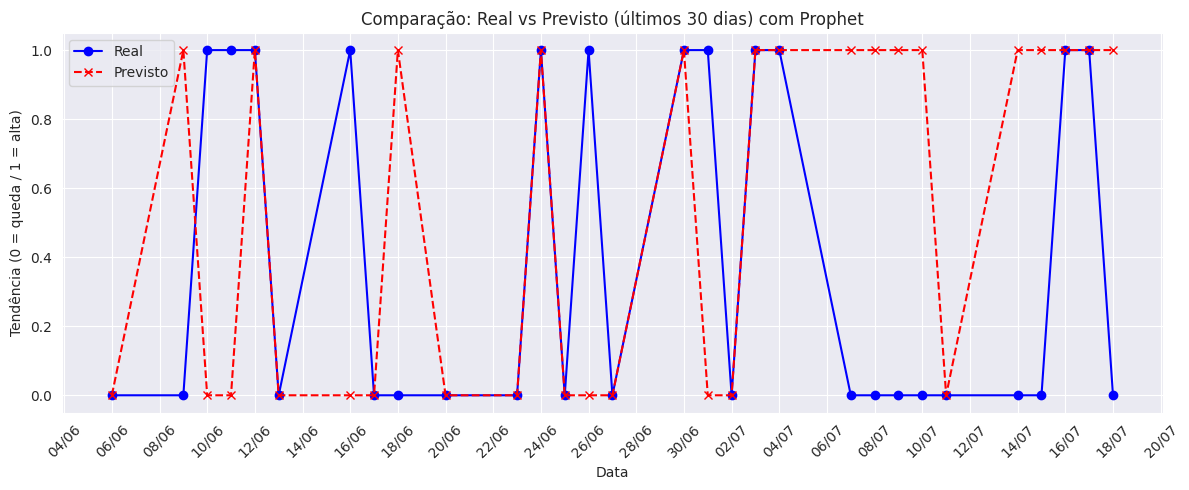

In [46]:
# Gráfico de comparação de classes

fig, ax = plt.subplots(figsize=(12, 5))

# Plotagem
ax.plot(comparacao['ds'], comparacao['y_class'], label='Real', marker='o', linestyle='-', color='blue')
ax.plot(comparacao['ds'], comparacao['yhat_class'], label='Previsto', marker='x', linestyle='--', color='red')

# Formatação do eixo x (datas)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)

# Rótulos e título
plt.title("Comparação: Real vs Previsto (últimos 30 dias) com Prophet")
plt.ylabel("Tendência (0 = queda / 1 = alta)")
plt.xlabel("Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

O grafico mostra efetivamente os último 30 dias que o modelo fez a predição. Acertando 16 dias de 30 dias conseguindo 53% de acerto.

### Avaliação com o modelo estatístico **XGBoostClassifier**

In [47]:
# Criar target
dados['target'] = (dados['y'].shift(-1) > dados['y']).astype(int)

In [48]:
# Criar feature de lag
dados['lag_1'] = dados['y'].shift(1)

In [49]:
# Separar treino e teste
X = dados[['lag_1']]
y = dados['target']

X_train = X.iloc[:-30]
X_test = X.iloc[-30:]
y_train = y.iloc[:-30]
y_test = y.iloc[-30:]

In [50]:
# Treinar modelo
model = XGBClassifier(n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss')
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)]);

[0]	validation_0-logloss:0.69138	validation_1-logloss:0.70339
[1]	validation_0-logloss:0.69084	validation_1-logloss:0.70328


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:09:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[2]	validation_0-logloss:0.69018	validation_1-logloss:0.70230
[3]	validation_0-logloss:0.68953	validation_1-logloss:0.70246
[4]	validation_0-logloss:0.68897	validation_1-logloss:0.69896
[5]	validation_0-logloss:0.68829	validation_1-logloss:0.69897
[6]	validation_0-logloss:0.68779	validation_1-logloss:0.69871
[7]	validation_0-logloss:0.68723	validation_1-logloss:0.69804
[8]	validation_0-logloss:0.68676	validation_1-logloss:0.69709
[9]	validation_0-logloss:0.68618	validation_1-logloss:0.69627
[10]	validation_0-logloss:0.68576	validation_1-logloss:0.69624
[11]	validation_0-logloss:0.68564	validation_1-logloss:0.69617
[12]	validation_0-logloss:0.68523	validation_1-logloss:0.69571
[13]	validation_0-logloss:0.68488	validation_1-logloss:0.69226
[14]	validation_0-logloss:0.68443	validation_1-logloss:0.69198
[15]	validation_0-logloss:0.68401	validation_1-logloss:0.69162
[16]	validation_0-logloss:0.68364	validation_1-logloss:0.68994
[17]	validation_0-logloss:0.68346	validation_1-logloss:0.69004


In [51]:
y_pred = model.predict(X_test)

In [52]:
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.5666666666666667
Matriz de Confusão:
 [[15  3]
 [10  2]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.60      0.83      0.70        18
           1       0.40      0.17      0.24        12

    accuracy                           0.57        30
   macro avg       0.50      0.50      0.47        30
weighted avg       0.52      0.57      0.51        30



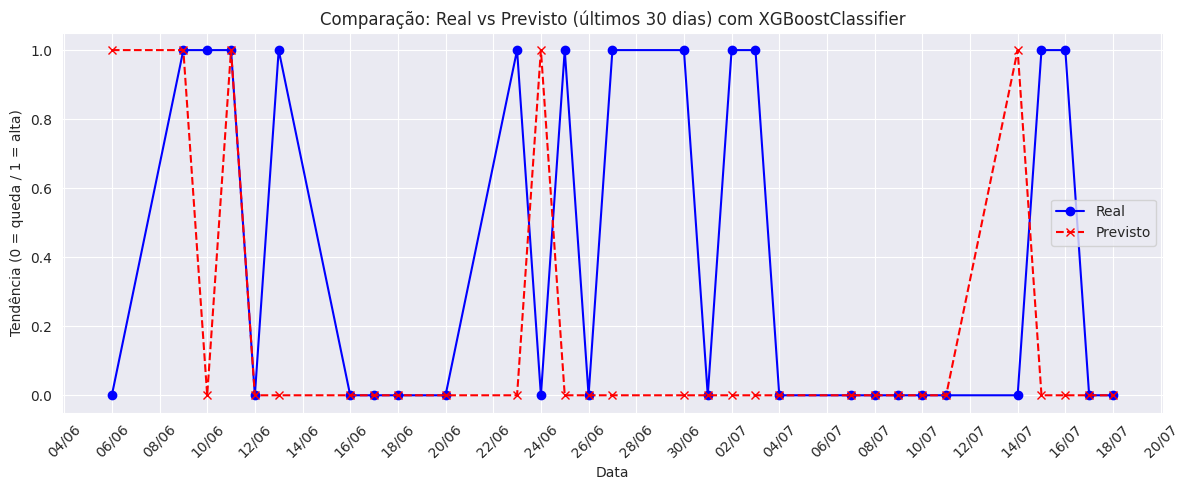

In [53]:
# Grafico dos valores reais comparado do da predição

# Criar dataframe com previsões
resultados = dados.tail(30).copy()
resultados['Real'] = y_test.values
resultados['Previsto'] = y_pred

# Garantir que a coluna 'ds' esteja em datetime
resultados['ds'] = pd.to_datetime(resultados['ds'])

# Gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Usar a coluna de datas como eixo x
ax.plot(resultados['ds'], resultados['Real'], label='Real', marker='o', linestyle='-', color='blue')
ax.plot(resultados['ds'], resultados['Previsto'], label='Previsto', marker='x', linestyle='--', color='red')

# Formatação do eixo x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # ou interval=1 se quiser mais detalhado
plt.xticks(rotation=45)

# Rótulos e legenda
plt.title("Comparação: Real vs Previsto (últimos 30 dias) com XGBoostClassifier")
plt.ylabel("Tendência (0 = queda / 1 = alta)")
plt.xlabel("Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

O grafico mostra efetivamente os último 30 dias que o modelo fez a predição. Acertando 17 dias de 30 dias conseguindo 56% de acerto.

#### Teste de Overfitting

In [54]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"Acurácia no treino: {acc_train:.4f}")
print(f"Acurácia no teste:  {acc_test:.4f}\n")

print("Relatório no teste:")
print(classification_report(y_test, y_pred_test))

Acurácia no treino: 0.6237
Acurácia no teste:  0.5667

Relatório no teste:
              precision    recall  f1-score   support

           0       0.60      0.83      0.70        18
           1       0.40      0.17      0.24        12

    accuracy                           0.57        30
   macro avg       0.50      0.50      0.47        30
weighted avg       0.52      0.57      0.51        30



Sobre Overfitting

Acurácia de treino: 62% — o modelo não obteve um aprendizado adequado nos dados históricos.

Acurácia de teste: 56% — é um valor bem abaixo/mediano para problemas de previsão de mercado financeiro.

Diferença de 6 pontos — ainda há alguma tendência de overfitting, constatando um possível leve overfitting.
O modelo quase não acerta quando o mercado sobe se olharmos o recall -1 de 0.17

### Avaliação com o modelo estatístico **RandomForestClassifier**

Aqui vamos usar o modelo de clasificação RandomForestClassifier, pois vamos clasificar dois valores algo longo do tempo 0 (caiu) e 1 (subiu) do dia seguinte para cada valor de fechamento do dia no Ibovespa.

In [55]:
# Criar target
dados['target'] = (dados['y'].shift(-1) > dados['y']).astype(int) # Criar uma coluna Target onde ele monstra se subiu ou caiu o valor no dia seguinte

In [56]:
# Criar feature de lag
dados['lag_1'] = dados['y'].shift(1)

Usamos somente uma feature de lag do dia anterior, pois adicionando outras features o modelo obtinha resultados piores. Tentamos outros lags e media móveis. Mas, sem nenhum ganho na predição.

In [57]:
# Separar treino e teste
X = dados[['lag_1']]
y = dados['target']

X_train = X.iloc[:-30]
X_test = X.iloc[-30:]
y_train = y.iloc[:-30]
y_test = y.iloc[-30:]

In [58]:
# Remover NaNs
dados = dados.dropna()

In [59]:
# Treinar modelo
model = RandomForestClassifier(n_estimators=500,max_depth=12, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=500, random_state=42)

In [60]:
# Previsões de probabilidade
y_proba = model.predict_proba(X_test)[:, 1]

# Novo limiar de decisão
threshold = 0.63
y_pred_thresh = (y_proba > threshold).astype(int)

# Resultado
print(f"Acurácia com threshold {threshold}: {round(accuracy_score(y_test, y_pred_thresh) * 100, 2)}%")
print(classification_report(y_test, y_pred_thresh))

Acurácia com threshold 0.63: 80.0%
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        18
           1       0.80      0.67      0.73        12

    accuracy                           0.80        30
   macro avg       0.80      0.78      0.78        30
weighted avg       0.80      0.80      0.80        30



Sem usar a previsão em probabilidades conseguimos resultado de até 70%, mas com threshold = 0.63. Conseguimos um resultado satisfatório de 80% com accuracy. Com uma f1-score de 84% para os valores 0 (caiu) e 73% para os valores 1 (subiu), além dos valores de recall e precison.

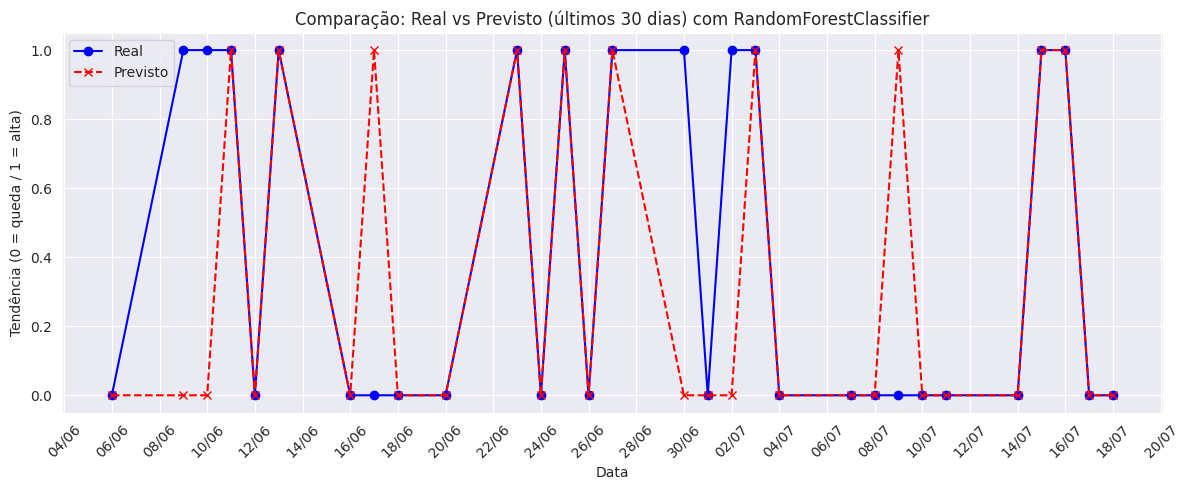

In [61]:
# Grafico dos valores reais comparado do da predição

# Criar dataframe com previsões
resultados = dados.tail(30).copy()
resultados['Real'] = y_test.values
resultados['Previsto'] = y_pred_thresh

# Garantir que a coluna 'ds' esteja em datetime
resultados['ds'] = pd.to_datetime(resultados['ds'])

# Gráfico
fig, ax = plt.subplots(figsize=(12, 5))

# Usar a coluna de datas como eixo x
ax.plot(resultados['ds'], resultados['Real'], label='Real', marker='o', linestyle='-', color='blue')
ax.plot(resultados['ds'], resultados['Previsto'], label='Previsto', marker='x', linestyle='--', color='red')

# Formatação do eixo x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # ou interval=1 se quiser mais detalhado
plt.xticks(rotation=45)

# Rótulos e legenda
plt.title("Comparação: Real vs Previsto (últimos 30 dias) com RandomForestClassifier")
plt.ylabel("Tendência (0 = queda / 1 = alta)")
plt.xlabel("Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

O grafico mostra efetivamente os último 30 dias que o modelo fez a predição. Acertando 24 dias de 30 dias conseguindo 80% de acerto.

#### Teste de Overfitting

In [62]:
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, model.predict(X_test))

print(f"Acurácia treino: {train_acc:.2f}")
print(f"Acurácia teste: {test_acc:.2f}")
print("\nClassification Report (teste):\n")
print(classification_report(y_test, model.predict(X_test)))

Acurácia treino: 0.82
Acurácia teste: 0.70

Classification Report (teste):

              precision    recall  f1-score   support

           0       0.85      0.61      0.71        18
           1       0.59      0.83      0.69        12

    accuracy                           0.70        30
   macro avg       0.72      0.72      0.70        30
weighted avg       0.74      0.70      0.70        30



Sobre Overfitting

Acurácia de treino: 82% — o modelo consegue aprender bem o padrão nos dados históricos.

Acurácia de teste: 70% — é um bom valor para problemas de previsão de mercado financeiro.

Diferença de 13 pontos — ainda há alguma tendência de overfitting, mas é aceitável em muitos contextos, especialmente com dados financeiros, que são muito ruidosos e difíceis de prever com alta precisão.